In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [32]:
df = pd.read_csv('../Dataset_Model_Preprocessed.csv')
df = df.fillna(0)
df.head()

,ap_1,ap_2,ap_3,ap_4,ap_5,ap_6,ap_7,ap_8,ap_9,ap_10,...,ap_35,ap_36,ap_37,ap_38,ap_39,ap_40,ap_41,ap_42,ap_43,spot
0,-37.0,-41.0,0.0,0.0,0.0,0.0,-93.0,0.0,-74.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Lantai 1
1,-68.0,-69.0,0.0,-65.0,0.0,-76.0,0.0,-72.0,-79.0,-81.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Lantai 1
2,-53.0,-56.0,0.0,-68.0,0.0,-67.0,-82.0,-76.0,-76.0,-76.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Lantai 1
3,-69.0,-74.0,-62.0,-59.0,-87.0,-35.0,-49.0,-60.0,-75.0,-59.0,...,0.0,0.0,0.0,0.0,-83.0,0.0,0.0,0.0,0.0,Lantai 1
4,-63.0,-58.0,0.0,-76.0,0.0,-77.0,0.0,0.0,-65.0,-85.0,...,0.0,0.0,-80.0,0.0,0.0,0.0,0.0,-72.0,0.0,Lantai 1


In [33]:
X = df.drop('spot', axis=1)
y = df['spot']

In [34]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
num_classes = len(le.classes_)
print("Dataset loaded and preprocessed successfully.")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y_encoded.shape}")
print(f"Number of unique spots (classes): {num_classes}")
print(f"Spot names: {le.classes_}")

Dataset loaded and preprocessed successfully.
Features shape: (86, 43)
Target shape: (86,)
Number of unique spots (classes): 4
Spot names: ['Lantai 1' 'Lantai 2' 'Lantai 3' 'Lantai 4']



--- Percobaan Training Size ---
Training Size: 10%, Test Size: 90%, Accuracy: 0.5769
Training Size: 20%, Test Size: 80%, Accuracy: 0.9130
Training Size: 30%, Test Size: 70%, Accuracy: 0.9508
Training Size: 40%, Test Size: 60%, Accuracy: 0.9808
Training Size: 50%, Test Size: 50%, Accuracy: 0.9535
Training Size: 60%, Test Size: 40%, Accuracy: 0.9714
Training Size: 70%, Test Size: 30%, Accuracy: 0.9615
Training Size: 80%, Test Size: 20%, Accuracy: 0.9444
Training Size: 90%, Test Size: 10%, Accuracy: 0.8889


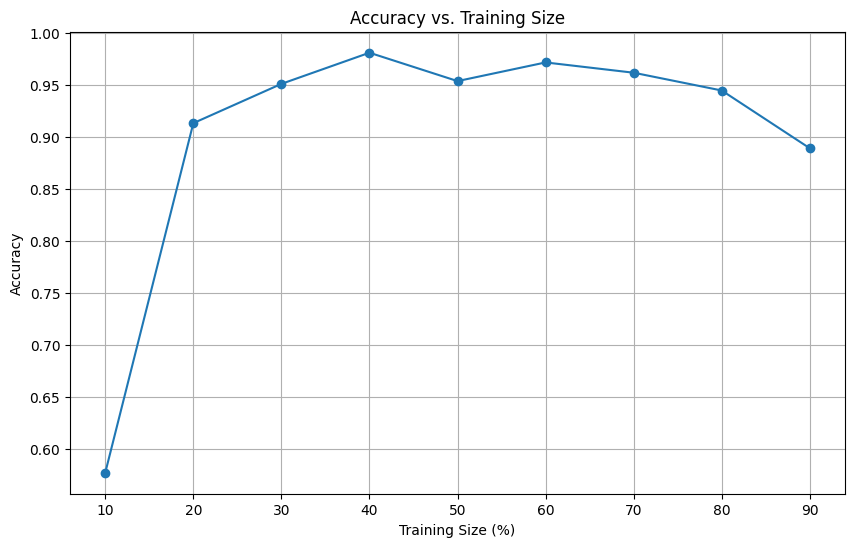

In [35]:
print("\n--- Percobaan Training Size ---")
training_sizes = np.arange(0.1, 1.0, 0.1)
accuracy_scores_ts = []
for ts in training_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=1-ts, random_state=42, stratify=y_encoded)
    knn = KNeighborsClassifier(n_neighbors=5) # Using a default k=5 for this test
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracy_scores_ts.append(acc)
    print(f"Training Size: {ts*100:.0f}%, Test Size: {(1-ts)*100:.0f}%, Accuracy: {acc:.4f}")
# Plotting Training Size vs. Accuracy
plt.figure(figsize=(10, 6))
plt.plot(training_sizes * 100, accuracy_scores_ts, marker='o')
plt.title('Accuracy vs. Training Size')
plt.xlabel('Training Size (%)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

In [38]:
print("\n--- Hypertuning Parameter (Grid Search) ---")
X_train_ht, X_test_ht, y_train_ht, y_test_ht = train_test_split(X, y_encoded, test_size=0.6, random_state=42, stratify=y_encoded)
param_grid = {
    'n_neighbors': np.arange(1, 21),  
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
knn_gs = KNeighborsClassifier()
grid_search = GridSearchCV(knn_gs, param_grid, cv=5, scoring='accuracy', n_jobs=1)
grid_search.fit(X_train_ht, y_train_ht)
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")


--- Hypertuning Parameter (Grid Search) ---
Best parameters found: {'metric': 'manhattan', 'n_neighbors': np.int64(15), 'weights': 'distance'}
Best cross-validation accuracy: 1.0000


In [39]:
best_knn_model = grid_search.best_estimator_
y_pred_ht = best_knn_model.predict(X_test_ht)
test_accuracy_ht = accuracy_score(y_test_ht, y_pred_ht)
print(f"Test set accuracy with best parameters: {test_accuracy_ht:.4f}")

Test set accuracy with best parameters: 0.9615


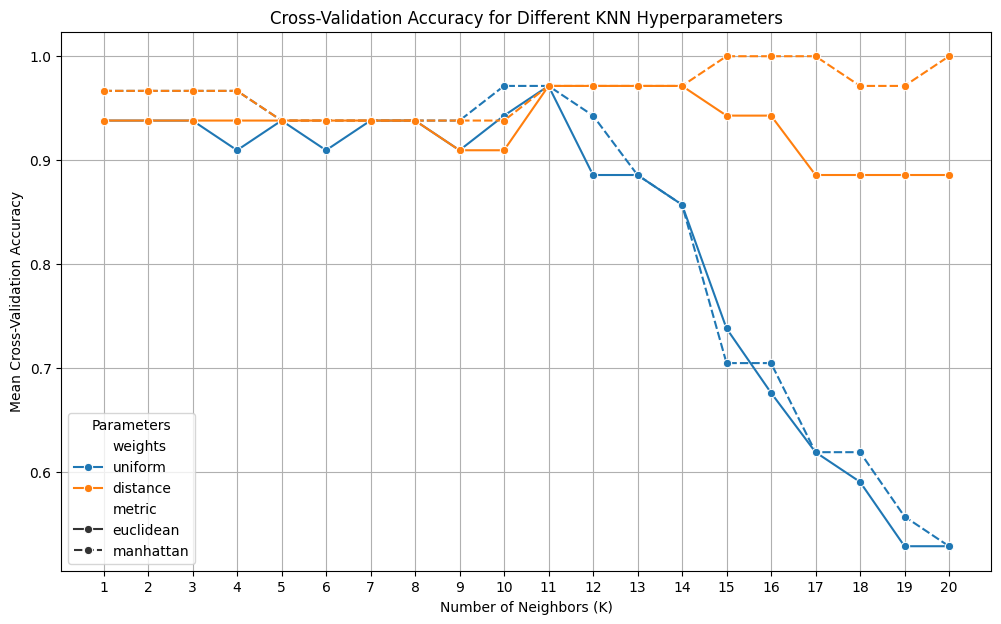

In [41]:
results = grid_search.cv_results_
mean_test_scores = results['mean_test_score']
params = results['params']
# Extract n_neighbors for plotting
k_values = [p['n_neighbors'] for p in params]
weights_values = [p['weights'] for p in params]
metric_values = [p['metric'] for p in params]
# Create a DataFrame for easier plotting
results_df = pd.DataFrame(params)
results_df['mean_test_score'] = mean_test_scores
plt.figure(figsize=(12, 7))
sns.lineplot(data=results_df, x='n_neighbors', y='mean_test_score', hue='weights', style='metric', marker='o')
plt.title('Cross-Validation Accuracy for Different KNN Hyperparameters')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.xticks(np.arange(1, 21, 1))
plt.grid(True)
plt.legend(title='Parameters')
plt.show()

In [42]:
# --- Tuning K-Fold Cross Validation dari KNN ---
print("\n--- 3. Tuning K-Fold Cross Validation dari KNN ---")
# Using the best parameters found from GridSearchCV
optimal_k = grid_search.best_params_['n_neighbors']
optimal_weights = grid_search.best_params_['weights']
optimal_metric = grid_search.best_params_['metric']
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, weights=optimal_weights, metric=optimal_metric)
# Perform K-Fold Cross Validation
cv_scores = cross_val_score(knn_optimal, X, y_encoded, cv=10, scoring='accuracy', n_jobs=-1) # Using 10 folds
print(f"Cross-validation accuracies for each fold: {cv_scores}")
print(f"Mean cross-validation accuracy: {cv_scores.mean():.4f}")
print(f"Standard deviation of cross-validation accuracy: {cv_scores.std():.4f}")


--- 3. Tuning K-Fold Cross Validation dari KNN ---
Cross-validation accuracies for each fold: [1.         0.77777778 1.         1.         1.         1.
 1.         1.         1.         1.        ]
Mean cross-validation accuracy: 0.9778
Standard deviation of cross-validation accuracy: 0.0667


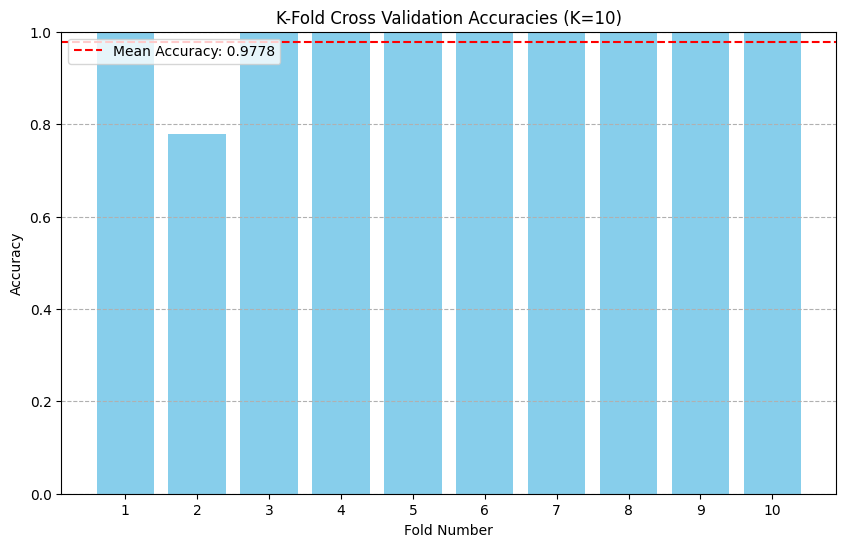

In [43]:
# Plotting K-Fold Cross Validation Results
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(cv_scores) + 1), cv_scores, color='skyblue')
plt.axhline(y=cv_scores.mean(), color='r', linestyle='--', label=f'Mean Accuracy: {cv_scores.mean():.4f}')
plt.title('K-Fold Cross Validation Accuracies (K=10)')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(range(1, len(cv_scores) + 1))
plt.grid(axis='y', linestyle='--')
plt.legend()
plt.show()

In [44]:
# --- Train the final model with best parameters on the full training data (from initial split) ---
# Re-split data for final model training and evaluation
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X, y_encoded, test_size=0.6, random_state=42, stratify=y_encoded)
final_knn_model = KNeighborsClassifier(n_neighbors=optimal_k, weights=optimal_weights, metric=optimal_metric)
final_knn_model.fit(X_train_final, y_train_final)
y_pred_final = final_knn_model.predict(X_test_final)
y_prob_final = final_knn_model.predict_proba(X_test_final) # For ROC/AUC

In [45]:
# --- Pengujian Confusion Matrix ---
print("\n--- 4. Pengujian Confusion Matrix ---")
cm = confusion_matrix(y_test_final, y_pred_final)
print("Confusion Matrix:")
print(cm)


--- 4. Pengujian Confusion Matrix ---
Confusion Matrix:
[[20  0  0  0]
 [ 1  8  0  0]
 [ 0  0 10  0]
 [ 1  0  0 12]]


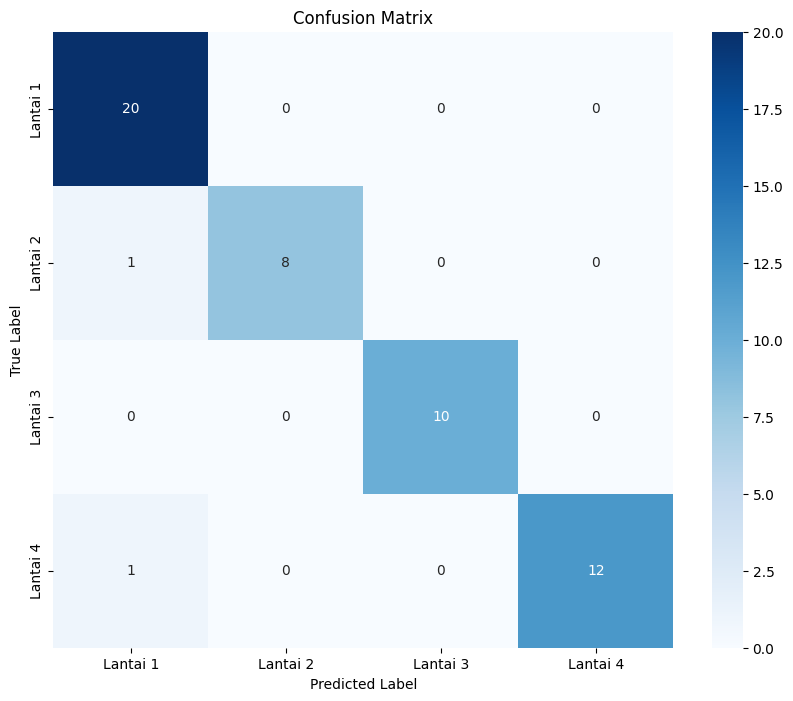

In [46]:
# Plotting Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [47]:
# Detect actual and predicted counts
actual_counts = np.bincount(y_test_final, minlength=num_classes)
predicted_counts = np.bincount(y_pred_final, minlength=num_classes)
print("\nActual vs. Predicted Counts per Class:")
for i, class_name in enumerate(le.classes_):
    print(f"Class '{class_name}': Actual = {actual_counts[i]}, Predicted = {predicted_counts[i]}")


Actual vs. Predicted Counts per Class:
Class 'Lantai 1': Actual = 20, Predicted = 22
Class 'Lantai 2': Actual = 9, Predicted = 8
Class 'Lantai 3': Actual = 10, Predicted = 10
Class 'Lantai 4': Actual = 13, Predicted = 12


In [48]:
# --- 5. Akurasi, Presisi, Recall, dan F1 Score dari Confusion Matrix ---
print("\n--- 5. Akurasi, Presisi, Recall, dan F1 Score ---")
accuracy = accuracy_score(y_test_final, y_pred_final)
precision = precision_score(y_test_final, y_pred_final, average='weighted')
recall = recall_score(y_test_final, y_pred_final, average='weighted')
f1 = f1_score(y_test_final, y_pred_final, average='weighted')
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1-Score (weighted): {f1:.4f}")


--- 5. Akurasi, Presisi, Recall, dan F1 Score ---
Accuracy: 0.9615
Precision (weighted): 0.9650
Recall (weighted): 0.9615
F1-Score (weighted): 0.9615



--- Penghitungan ROC dan AUC ---


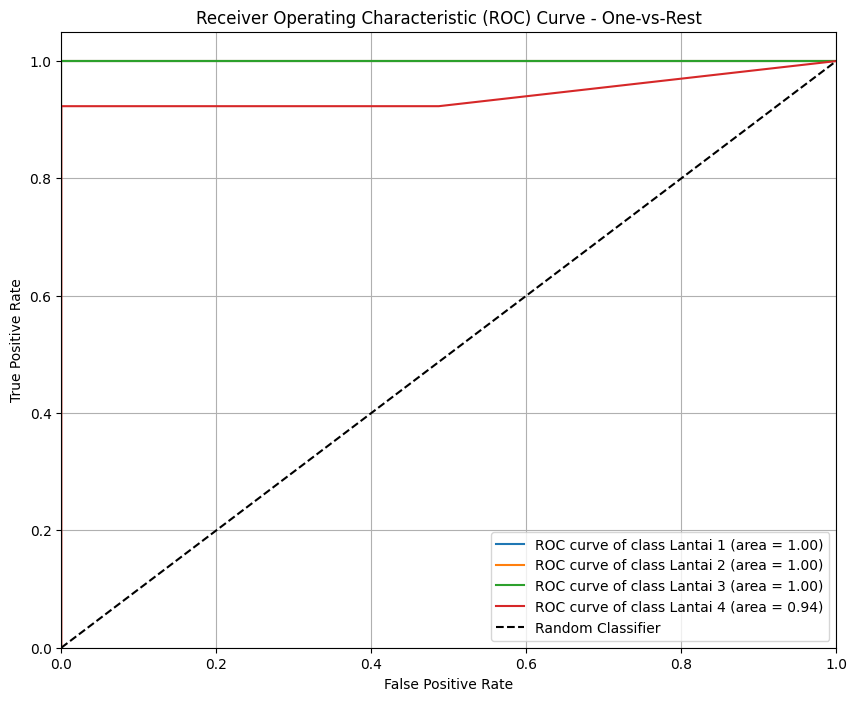

In [49]:
# --- Penghitungan ROC dan AUC ---
print("\n--- Penghitungan ROC dan AUC ---")
from sklearn.preprocessing import label_binarize
y_test_binarized = label_binarize(y_test_final, classes=np.arange(num_classes))
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_prob_final[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {le.classes_[i]} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - One-vs-Rest')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


--- Calculate Sensitivity and Specificity ---
Sensitivity per class: [np.float64(1.0), np.float64(0.8888888888888888), np.float64(1.0), np.float64(0.9230769230769231)]
Specificity per class: [np.float64(0.9375), np.float64(1.0), np.float64(1.0), np.float64(1.0)]
Average Sensitivity: 0.9530
Average Specificity: 0.9844


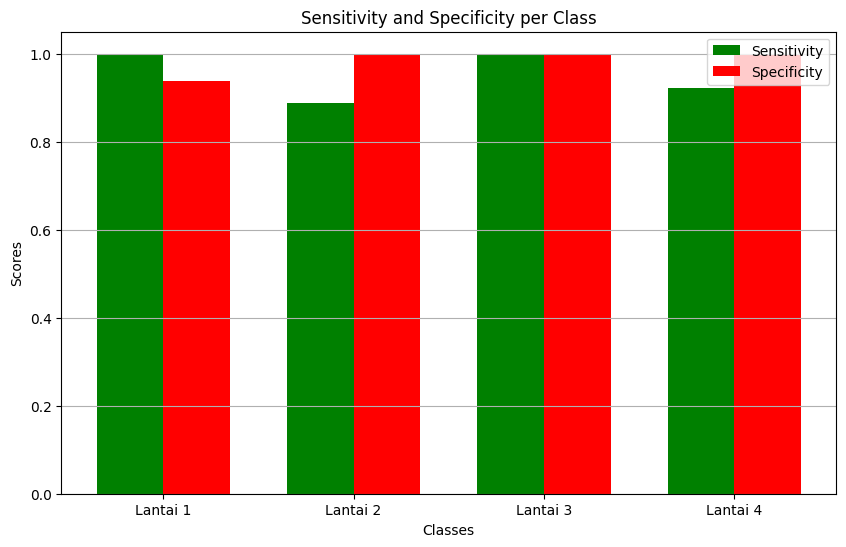

In [50]:
# --- Calculate Sensitivity and Specificity ---
print("\n--- Calculate Sensitivity and Specificity ---")

# Calculate True Positives, False Positives, False Negatives for each class
conf_matrix = confusion_matrix(y_test_final, y_pred_final)
sensitivity = []
specificity = []

for i in range(num_classes):
    TP = conf_matrix[i, i]
    FN = np.sum(conf_matrix[i, :]) - TP  # All positives for class i minus true positives
    FP = np.sum(conf_matrix[:, i]) - TP  # All predicted positives for class i minus true positives
    TN = np.sum(conf_matrix) - (FP + FN + TP)  # Total samples minus FP, FN, TP

    sensitivity.append(TP / (TP + FN) if (TP + FN) > 0 else 0)
    specificity.append(TN / (TN + FP) if (TN + FP) > 0 else 0)

print("Sensitivity per class:", sensitivity)
print("Specificity per class:", specificity)

# Average Sensitivity and Specificity
avg_sensitivity = np.mean(sensitivity)
avg_specificity = np.mean(specificity)
print(f"Average Sensitivity: {avg_sensitivity:.4f}")
print(f"Average Specificity: {avg_specificity:.4f}")

# --- Plotting Sensitivity and Specificity ---
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(num_classes)

# Plot Sensitivity
plt.bar(index, sensitivity, bar_width, label='Sensitivity', color='g')

# Plot Specificity
plt.bar(index + bar_width, specificity, bar_width, label='Specificity', color='r')

plt.xlabel('Classes')
plt.ylabel('Scores')
plt.title('Sensitivity and Specificity per Class')
plt.xticks(index + bar_width / 2, le.classes_)
plt.legend()
plt.grid(axis='y')
plt.show()



--- 7. Learning Curve Training dan Validation Set ---


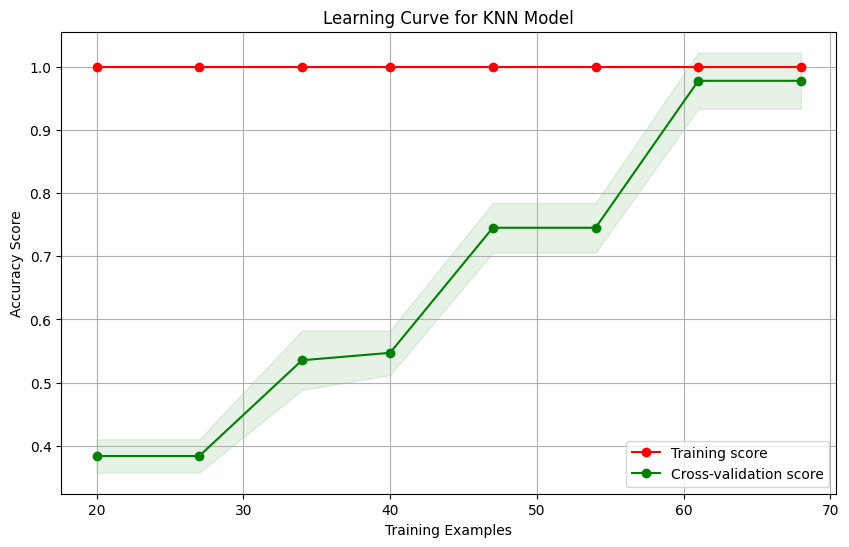

In [51]:
# --- Learning Curve Training dan Validation Set ---
print("\n--- 7. Learning Curve Training dan Validation Set ---")
train_sizes, train_scores, val_scores = learning_curve(
    final_knn_model, X, y_encoded, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, val_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.title('Learning Curve for KNN Model')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy Score')
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [52]:
# --- Prediksi dengan Model yang Paling Best ---
print("\n--- 8. Prediksi dengan Model yang Paling Best ---")
# The 'final_knn_model' is the best model trained with optimal hyperparameters
# Let's use a few samples from the test set for demonstration
sample_indices = np.random.choice(len(X_test_final), 5, replace=False)
sample_X = X_test_final.iloc[sample_indices]
sample_y_actual = y_test_final[sample_indices]
sample_predictions = final_knn_model.predict(sample_X)
sample_probabilities = final_knn_model.predict_proba(sample_X)
print("Sample Predictions:")
for i, idx in enumerate(sample_indices):
    actual_label = le.inverse_transform([sample_y_actual[i]])[0]
    predicted_label = le.inverse_transform([sample_predictions[i]])[0]
    print(f"Sample {i+1}:")
    print(f"  Actual Spot: {actual_label}")
    print(f"  Predicted Spot: {predicted_label}")
    print(f"  Prediction Probabilities: {sample_probabilities[i]}")
    print("-" * 30)


--- 8. Prediksi dengan Model yang Paling Best ---
Sample Predictions:
Sample 1:
  Actual Spot: Lantai 3
  Predicted Spot: Lantai 3
  Prediction Probabilities: [0.04824347 0.13243989 0.62308636 0.19623028]
------------------------------
Sample 2:
  Actual Spot: Lantai 4
  Predicted Spot: Lantai 4
  Prediction Probabilities: [0.07588507 0.03989127 0.15567023 0.72855343]
------------------------------
Sample 3:
  Actual Spot: Lantai 4
  Predicted Spot: Lantai 4
  Prediction Probabilities: [0.04746847 0.05336589 0.23088876 0.66827689]
------------------------------
Sample 4:
  Actual Spot: Lantai 2
  Predicted Spot: Lantai 2
  Prediction Probabilities: [0.19270254 0.60939333 0.15911957 0.03878457]
------------------------------
Sample 5:
  Actual Spot: Lantai 4
  Predicted Spot: Lantai 4
  Prediction Probabilities: [0.04208784 0.04038814 0.23904751 0.67847651]
------------------------------


In [55]:
# --- Hasil Evaluasi Model ---
print("\n--- 9. Hasil Evaluasi Model ---")
print("Summary of Model Evaluation:")
print(f"Optimal K: {optimal_k}")
print(f"Optimal Weights: {optimal_weights}")
print(f"Optimal Metric: {optimal_metric}")
print(f"Best Cross-Validation Accuracy (from Grid Search): {grid_search.best_score_:.4f}")
print(f"Test Set Accuracy (with best model): {test_accuracy_ht:.4f}")
print(f"Mean K-Fold Cross-Validation Accuracy (10 folds): {cv_scores.mean():.4f}")
print(f"Overall Accuracy on Final Test Set: {accuracy:.4f}")
print(f"Overall Precision (weighted): {precision:.4f}")
print(f"Overall Recall (weighted): {recall:.4f}")
print(f"Overall F1-Score (weighted): {f1:.4f}")


--- 9. Hasil Evaluasi Model ---
Summary of Model Evaluation:
Optimal K: 15
Optimal Weights: distance
Optimal Metric: manhattan
Best Cross-Validation Accuracy (from Grid Search): 1.0000
Test Set Accuracy (with best model): 0.9615
Mean K-Fold Cross-Validation Accuracy (10 folds): 0.9778
Overall Accuracy on Final Test Set: 0.9615
Overall Precision (weighted): 0.9650
Overall Recall (weighted): 0.9615
Overall F1-Score (weighted): 0.9615
